# Bayesian Linear Regression

Implementation of a 2D Bayesian Linear Regression.

The following sources helped me understand the mathematics behind a Bayesian Linear Regressor, and they gave me useful practical insights for its development:
- [Nando De Freitas' lecture series on Bayesian ML](https://www.youtube.com/watch?v=w2OtwL5T1ow&ab_channel=NandodeFreitas)
- [Anna-Lena Popkes' notebook on bayesian Linear Regression](https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/)
- [Chapter 9 of Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from mpl_toolkits.mplot3d import Axes3D

## Dataset
First, let's generate some data with the following values:
- Gaussian noise: $\mathcal{N}$(0, $\sigma$= 0.5)
- slope: 0.9
- intercept: -0.7

In [2]:
# Generate true values and noise corrupted targets
n_datapoints = 500
intercept = -0.7 
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = 0
upper_bound = 3

# Generate dataset
x = np.random.uniform(lower_bound, upper_bound, n_datapoints)
y = intercept + slope*x + np.random.normal(0, noise_std_dev, size=len(x))

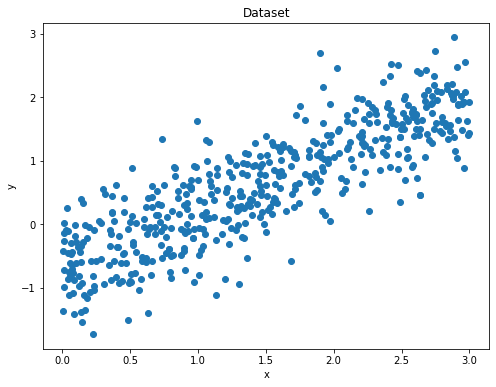

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Util function to plot 3D distributions:

In [4]:
def print_3D_distribution(x_lim, y_lim, prob, x_label=None, y_label=None, title=None):
    #Make a 3D plot
    x = np.linspace(x_lim[0],x_lim[1],200)
    y = np.linspace(y_lim[0],y_lim[1],200)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, prob.pdf(pos),cmap='viridis',linewidth=0)
    ax.set_zlabel('pdf')
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    plt.show()
    
def plot_param_posterior(lower_bound, upper_bound, blr, title):
    fig = plt.figure()
    mesh_features, mesh_labels = np.mgrid[lower_bound:upper_bound:.01, lower_bound:upper_bound:.01]
    pos = np.dstack((mesh_features, mesh_labels))
    plt.contourf(mesh_features, mesh_labels, blr.param_posterior.pdf(pos), levels=15)
    plt.scatter(intercept, slope, color='red', label="True parameter values")
    plt.title(title)
    plt.xlabel("Intercept")
    plt.ylabel("Slope")
    plt.legend();

## Goal
Our **goal** is to find the values that describe this probabilistic model using a Bayesian approach.

## Prior
We need a prior $p(\theta) = \mathcal{N}(\theta | \theta_0, V_0)$ on the parameters $\theta$ of our Linear Regression (slope and intercept). 

$\theta_0$: vector containing the means of our parameters \
$V_0$: covariance matrix of our parameters

Let's assume: 

$ \theta_0 = 
\begin{bmatrix}
    \theta_{0,\text{intercept}} \\
    \theta_{0,\text{slope}}\\
\end{bmatrix} = 
\begin{bmatrix}
    0 \\
    0\\
\end{bmatrix}
$

$ V_0 = 
\begin{bmatrix}
    0 \ \ 0.5 \\
    0.5 \ \ 0\\
\end{bmatrix}
$

Therefore: $p(\theta)$:


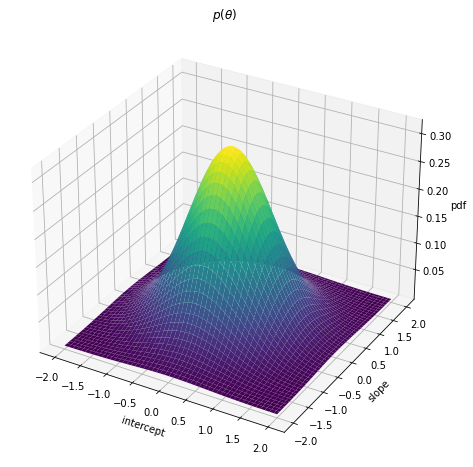

In [5]:
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])
prior = multivariate_normal(prior_mean, prior_cov)

# Print the prior
print_3D_distribution([-2, 2], [-2, 2], prior, 'intercept', 'slope', r'$p(\theta)$')

## Posterior
In the slides, we saw that the posterior $p( \theta | y) = \mathcal{N}(\theta | \theta_n, V_n)$, where:

$$V_n = (V_0^{-1} + \frac{1}{\sigma^2}\mathbf{X^T}\mathbf{X})^{-1}$$ \
$$\theta_n = V_n \ (V_0^{-1}\theta_0 + \frac{1}{\sigma^2}\mathbf{X}^T\mathbf{y})$$

In a linear model:
$$\mathbf{X} = 
\begin{bmatrix}
    1 \ \ x_{11} \ \ ... \ \ x_{1m} \\
    . \ \ . \ \ . \ \  . \ \  . \ \ . \\
    1 \ \ x_{n1} \ \ ... \ \ x_{nm}
\end{bmatrix}
$$
We call this *design matrix*.

## Model

In [6]:
class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (theta_0 in the slides)
        prior_cov: Covariance matrix of the prior distribution (V_0 in the slides)
        noise_var: Variance of the noise distribution
    """
    def __init__(self, prior_mean, prior_cov, noise_var):
        # Initialise prior
        self.prior_mean = prior_mean[:, np.newaxis]  # column vector of shape (1, d)
        self.prior_cov = prior_cov  # matrix of shape (d, d)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # Initialise the variance of the noise
        self.noise_var = noise_var  # single float value
        
        # At first, the posterior is equal to the prior
        self.param_posterior = self.prior
        # At first, the posterior mean and covariance is equal to the prior mean and variance
        self.post_mean = self.prior_mean # theta_N in formulas
        self.post_cov = self.prior_cov # V_N in formulas
        self.pred_cov=None
        self.pred_mean=None
        
    def update_posterior(self, x, y):
        """
        Update the posterior given new features and targets
    
        Args:
            x: numpy array of features
            y: numpy array of targets
        """
        # Reshape targets to allow correct matrix multiplication
        # Input shape is (N,) but we need (N, 1)
        y = y[:, np.newaxis]
        
        # Compute the design matrix, shape (N, 2)
        X = self.compute_design_matrix(x)

        # Update the covariance matrix, shape (2, 2)
        X_dot_product = X.T.dot(X)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.V_n = np.linalg.inv(inv_prior_cov +  1/self.noise_var * X_dot_product)
        
        # Update the mean, shape (2, 1)
        self.theta_n = self.V_n.dot( 
                         inv_prior_cov.dot(self.prior_mean) + 
                         1/self.noise_var * X.T.dot(y))

        
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.theta_n.flatten(), self.V_n)
    
    def compute_design_matrix(self, x):
        # Adding a column of 1s to our feature matrix to compute the intercept.
        n_samples = len(x)
        ones = np.ones(n_samples)
        design_matrix = np.stack((ones, x), axis=1)
        return design_matrix
    
    def predict(self, x):
        """
        Compute predictive posterior given new datapoint

        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        X = self.compute_design_matrix(x)
        
        self.pred_mean = X.dot(self.theta_n)
        self.pred_cov =  self.noise_var + X.dot(self.V_n.dot(X.T))
        pred_posterior = norm(self.pred_mean.flatten(), np.sqrt(self.pred_cov))
        return pred_posterior

Let's instantiate the Bayesian Linear Regression model with some initial mean vector and covariance matrix:

In [7]:
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])

blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

The initial posterior of the two parameters of the line is equal to the prior:

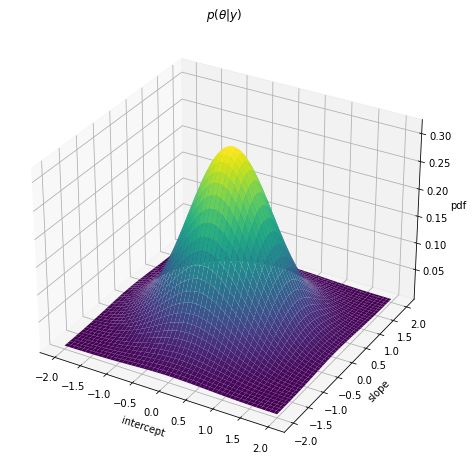

In [8]:
print_3D_distribution([-2, 2], [-2, 2], blr.param_posterior, 'intercept', 'slope', r'$p(\theta | y)$')

We can visualise the learning process after $n$ updates. The list `n_points_list` contains a sequence of number representing the number of data points to use to train the regressor at each step. That is, the model is first trained on the `1st` data point, then with the first `5` data points, etc.. 

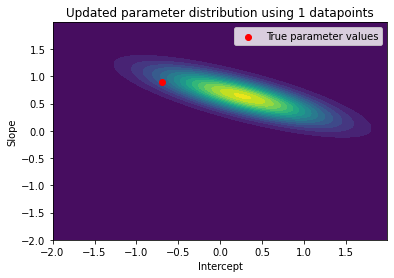

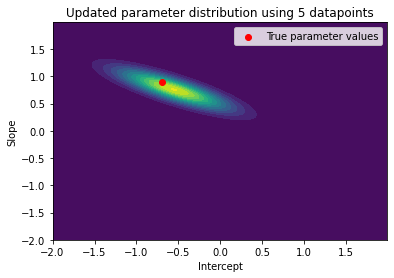

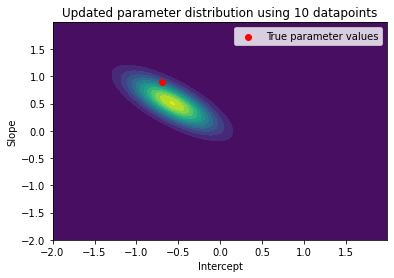

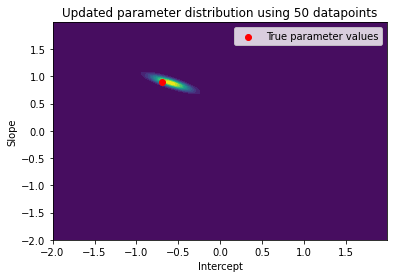

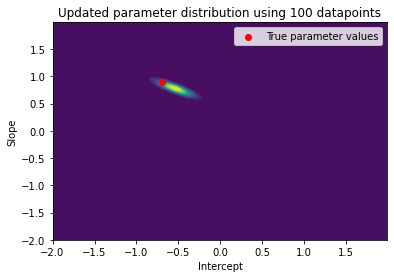

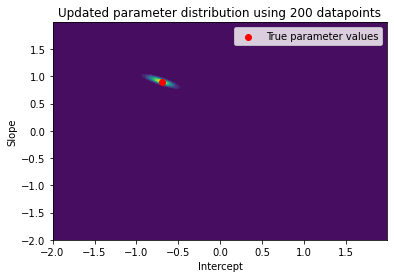

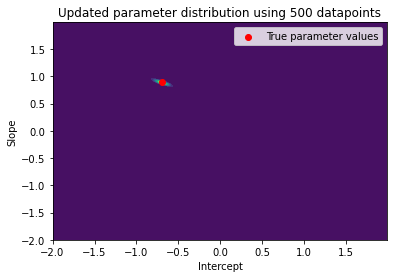

In [9]:
n_points_list = [1, 5, 10, 50, 100, 200, 500]
previous_n_points = 0
for n_points in n_points_list:
    train_features = x[previous_n_points:n_points]
    train_labels = y[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    
    # Visualize updated parameter posterior distribution
    plot_param_posterior(-2, 
                         2, 
                         blr, 
                         title=f"Updated parameter distribution using {n_points} datapoints")
    
    previous_n_points = n_points

We can visualise the same plots in 3D:

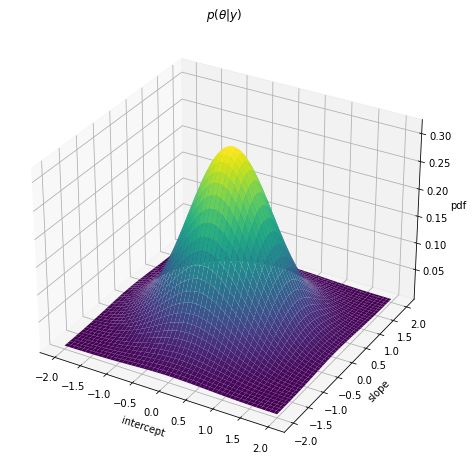

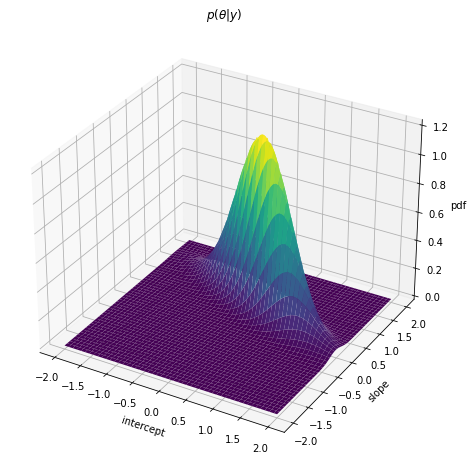

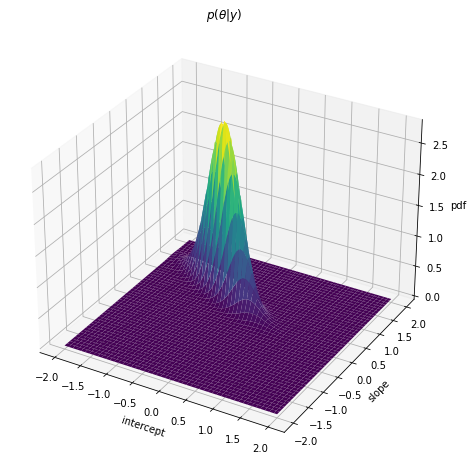

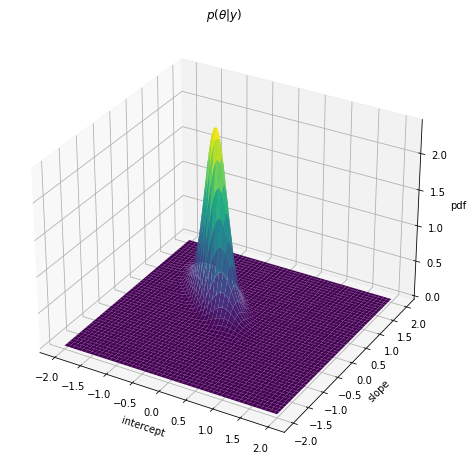

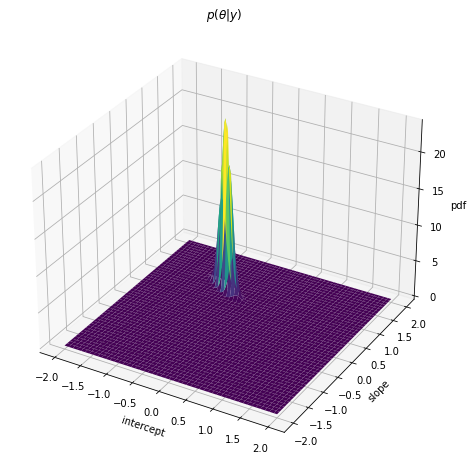

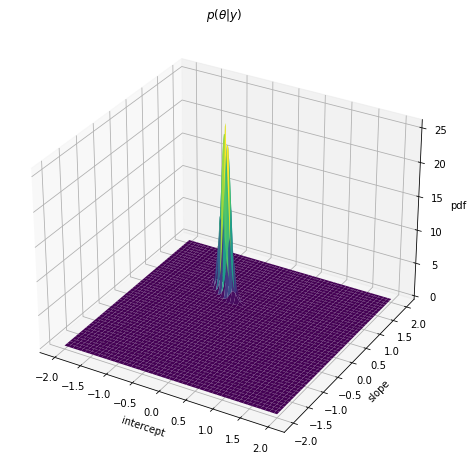

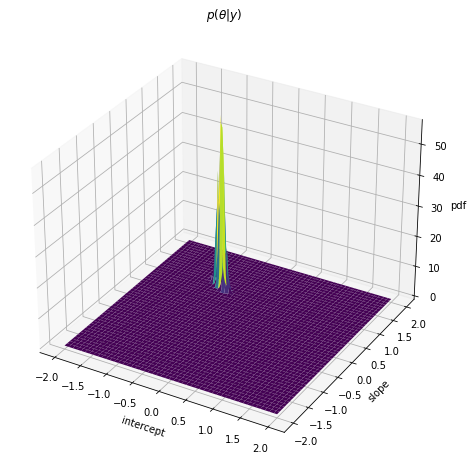

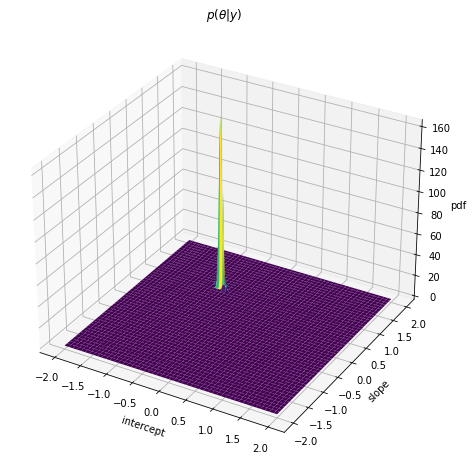

In [10]:
# Let's make sure that we can initialize our model
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)
print_3D_distribution([-2, 2], [-2, 2], blr.param_posterior, 'intercept', 'slope', r'$p(\theta | y)$')
n_points_lst = [1, 5, 10, 50, 100, 200, 500]
previous_n_points = 0
for n_points in n_points_lst:
    train_features = x[previous_n_points:n_points]
    train_labels = y[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    print_3D_distribution([-2, 2], [-2, 2], blr.param_posterior, 'intercept', 'slope', r'$p(\theta | y)$')
    previous_n_points = n_points

Now, after training the model with `500` data points, we want to show that the variance of the predicted posterior is higher for out-of-distribution data points than in-distribution ones:

### In-distribution

In [11]:
x_star = 2

pred_post = blr.predict(np.array([x_star]))
pred_mean = pred_post.mean()[0][0]
pred_std_dev = np.sqrt(pred_post.var())[0][0]
print(pred_std_dev, blr.pred_cov[0][0])
print(f'The prediction is {round(pred_mean, 3)} with a std_dev of {round(pred_std_dev, 3)}')
print(f'The real target is {round(-0.7 + x_star*0.9,4)}')

0.5010838612380843 0.25108503599326776
The prediction is 1.073 with a std_dev of 0.501
The real target is 1.1


### Out of distribution

In [12]:
x_star = 22

pred_post = blr.predict(np.array([x_star]))
pred_mean = pred_post.mean()[0][0]
pred_std_dev = np.sqrt(pred_post.var())[0][0]
print(f'The prediction is {round(pred_mean, 3)} with a std_dev of {round(pred_std_dev, 3)}')
print(f'The real target is {round(-0.7 + x_star*0.9, 4)}')

The prediction is 18.761 with a std_dev of 0.826
The real target is 19.1


[]

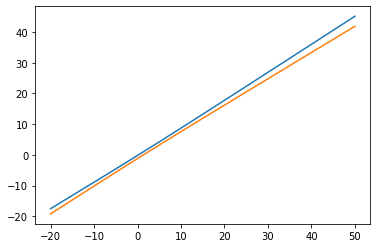

In [13]:
xs = np.arange(-20, 50, 0.01)
std_devs_upper = []
std_devs_lower = []

for x_star in xs:
    pred_post = blr.predict(np.array([x_star]))
    pred_mean = pred_post.mean()[0][0]
    pred_std_dev = np.sqrt(pred_post.var())[0][0]
    std_devs_upper.append(pred_mean + pred_std_dev)
    std_devs_lower.append(pred_mean - pred_std_dev)

plt.plot(xs, std_devs_upper)
plt.plot(xs, std_devs_lower)
plt.plot()